# Load packages

In [307]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm
from datetime import datetime
import datetime as dt
import csv
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [308]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,3
rcParams['axes.titlesize']=15
rcParams['font.size']=12
rcParams['figure.facecolor']= '0.75'
rcParams['legend.fontsize'] = 'small'
rcParams['figure.titlesize'] = 'small'
rcParams['legend.loc'] = 'upper right'

# Get historical data from Yahoo Finance API

In [309]:
start = dt.datetime(2007,1,1)
end = dt.datetime(2018,1,1)
data = web.DataReader('AMZN','yahoo',start,end)
#data.head()
#print(data.tail())

# Save the data in Excel sheet


In [310]:
excel = data.to_csv('StockMarketData_timeseries.csv')

# Select variables and Set Index

In [311]:
dataset = pd.read_csv('StockMarketData_timeseries.csv')
indexeddataset=dataset[['Date','Close']]
print(indexeddataset.head())

         Date      Close
0  2007-01-03  38.700001
1  2007-01-04  38.900002
2  2007-01-05  38.369999
3  2007-01-08  37.500000
4  2007-01-09  37.779999


In [312]:
#Set Index
indexeddataset.set_index('Date', inplace = True)

# convert it into datetime
indexeddataset.index=pd.to_datetime(indexeddataset.index)

#resample to month-wise data
indexeddataset=indexeddataset.resample('1M').mean()
print(indexeddataset.head())

                Close
Date                 
2007-01-31  37.563000
2007-02-28  39.495263
2007-03-31  38.655909
2007-04-30  46.629500
2007-05-31  64.559091


# Plot the Closing Price vs Time

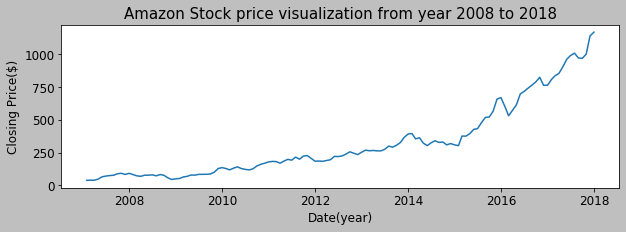

In [313]:
plt.xlabel('Date(year)')
plt.ylabel('Closing Price($)')
plt.title('Amazon Stock price visualization from year 2008 to 2018')
plt.plot(indexeddataset)

In [314]:
# Note: The above graph shows an Upward trend which means the data is not stationary.
#we can check the data stationary using rolling statistics and dickey-Fuller Test

# Check Data stationarity

In [315]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #calculate moving average
    movingAverage = timeseries.rolling(window = 12).mean()
    movingAverage_std = timeseries.rolling(window = 12).std()
   
    #plot rolling statistics
    original = plt.plot(timeseries, color = 'blue',label ='Original')
    mean = plt.plot(movingAverage, color ='red', label = 'Rolling Mean')
    std = plt.plot(movingAverage_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Date(year)')
    plt.ylabel('Closing price in log scale')
    plt.title('Rolling mean and Standard Deviation')
    plt.show()
    
    #perform dickey-fuller test
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test statistics','P-value','#Lags used','Closing Price'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] =  value
    print(dfoutput)


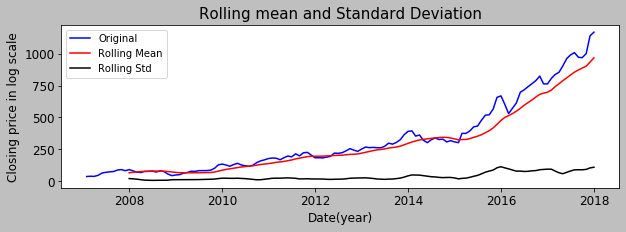

Result of Dickey-Fuller Test:
Test statistics           3.670397
P-value                   1.000000
#Lags used                3.000000
Closing Price           128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64


In [316]:
test_stationarity(indexeddataset)

In [317]:
#'Rolling Statistics Test' Analysis:
#I plotted the moving average by taking average of last 12 months to understand the past 12 Months Trend and 
#analyzed the data points and it can say that the rolling mean and standard deviation is moving and increasing.

# 'Dickey Fuller Test' Analysis:
#The P-values is 1.00 it should be less that 0.5. 
#Test Statistic’ is greater than Critical Value. 
#It should be less than the Critical Value to reject the null hypothesis.
#Stationary time series is when the mean and variance are constant over time. 
#Hence, It can be clearly observed that the data is not starionary.

# Steps to make Data Staionarity

Text(0.5, 1.0, 'Data in Log Scale')

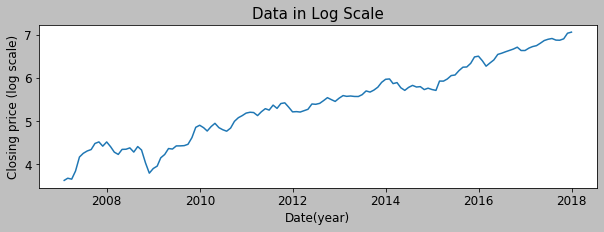

In [318]:
#Step 1. Log Transformation

#we saw in previos graph an upward trend, so we can apply log transformation to reduce the higher values to smaller values.
indexeddataset_log = np.log(indexeddataset)
plt.plot(indexeddataset_log)
plt.xlabel('Date(year)')
plt.ylabel('Closing price (log scale)')
plt.title('Data in Log Scale', fontsize=15)

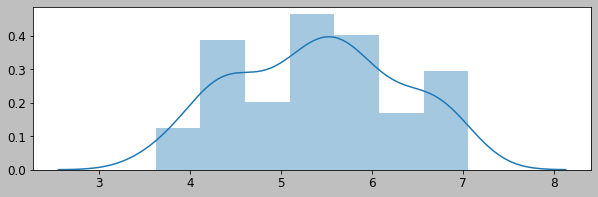

In [319]:
#Normal Distribution
sns.distplot(indexeddataset_log)

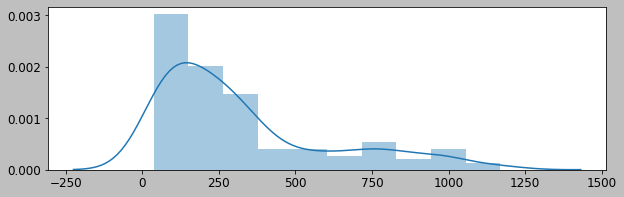

In [320]:
#Skwed data
sns.distplot(indexeddataset)

Text(0.5, 1.0, 'Moving Average')

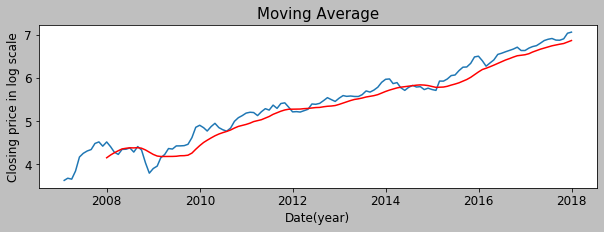

In [321]:
#Moving average
movingAverage = indexeddataset_log.rolling(window = 12).mean()
movingAverage_std = indexeddataset_log.rolling(window = 12).std()
plt.plot(indexeddataset_log)
plt.plot(movingAverage, color = 'Red')
plt.xlabel('Date(year)')
plt.ylabel('Closing price in log scale')
plt.title('Moving Average')

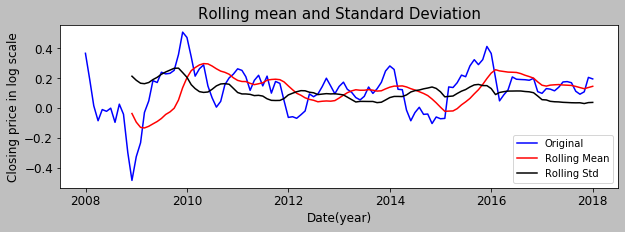

Result of Dickey-Fuller Test:
Test statistics          -4.052993
P-value                   0.001157
#Lags used                1.000000
Closing Price           119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


In [322]:
dataset_In_timeseries = indexeddataset_log - movingAverage
dataset_In_timeseries.dropna(inplace = True)
dataset_In_timeseries.head(20)

test_stationarity(dataset_In_timeseries)

In [323]:
#'Rolling Statistics Test' Analysis:
#I plotted the moving average by taking average of last 12 months to understand the past 12 Months Trend and 
#analyzed the data points and it can say that the rolling mean and standard deviation is less smooth, variations and better.

# 'Dickey Fuller Test' Result Analysis:
#The P-values is 0.001 which is less that 0.5. The Test-statistics and Critical Values for difference confidence levels.
#Test Statistic’ is less than the Critical Value to reject the null hypothesis.
#Stationary time series is when the mean and variance are constant over time. 
#Hence this look stationary data and look much better series.

#But disavantage of moving average is time-period has to be strictly defined.
#As this is stock price data, so it is always good practice to give the higher weights to recent values to forecast stock price.
#It can be easily done by using Exponentially weighted moving average approach.

# Exponentially weighted moving average

Text(0.5, 1.0, 'Exponentially Weighted Moving Average')

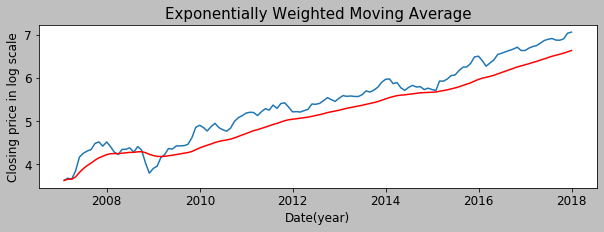

In [324]:
#to see the trend in the time series, ewm is applied on a series of data. It assigns the weights exponentially.

Exponential_weightedAverage = indexeddataset_log.ewm(halflife =10, min_periods=0, adjust = True).mean()
plt.plot(indexeddataset_log)
plt.plot(Exponential_weightedAverage, color='red')
plt.xlabel('Date(year)')
plt.ylabel('Closing price in log scale')
plt.title('Exponentially Weighted Moving Average')

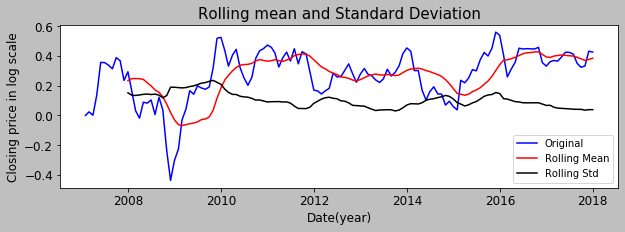

Result of Dickey-Fuller Test:
Test statistics          -3.669200
P-value                   0.004568
#Lags used                1.000000
Closing Price           130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64


In [325]:
Exponential_weightedAverage_Log = indexeddataset_log - Exponential_weightedAverage
test_stationarity(Exponential_weightedAverage_Log)

In [326]:
#'Rolling Statistics Test' Analysis:
#I used the Exponentially weighted moving average approach and analyzed the data points. 
#It can say that the rolling mean and standard deviation is less smooth, variations and better.

# 'Dickey Fuller Test' Result Analysis:
#The P-values is 0.004568 which is less that 0.5. The Test-statistics and Critical Values for difference confidence levels.
#Test Statistic’ is less than the Critical Value hence null hypothesis can be rejected.
#Stationary time series is when the mean and variance are constant over time. 
#Hence this look stationary data, lesser variations in mean and standard deviation in magnitude and look much better series.

# Differencing

Text(0.5, 1.0, 'Differencing for Eliminating Trend and Seasonality ')

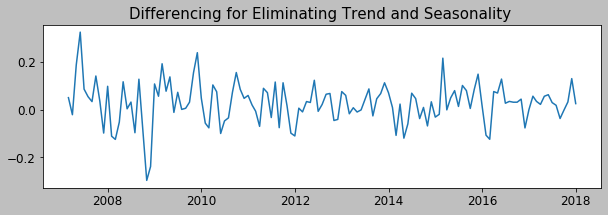

In [327]:
#Differencing is a method of transforming a non-stationary time series into a stationary one
#In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 
#This mostly works well in improving stationarity.

datasetLogShift = indexeddataset_log - indexeddataset_log.shift()
plt.plot(datasetLogShift)
plt.title('Differencing for Eliminating Trend and Seasonality ')


               Close
Date                
2007-02-28  0.050161
2007-03-31 -0.021481
2007-04-30  0.187534
2007-05-31  0.325348
2007-06-30  0.086030


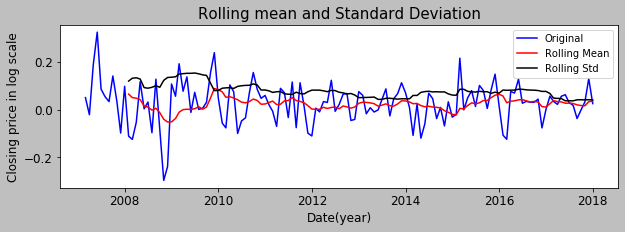

Result of Dickey-Fuller Test:
Test statistics        -6.922070e+00
P-value                 1.139731e-09
#Lags used              2.000000e+00
Closing Price           1.280000e+02
Critical Value (1%)    -3.482501e+00
Critical Value (5%)    -2.884398e+00
Critical Value (10%)   -2.578960e+00
dtype: float64


In [328]:
datasetLogShift.dropna(inplace=True)
print(datasetLogShift.head())
test_stationarity(datasetLogShift)

#Note: The timeseries is stationary

In [329]:
#'Rolling Statistics Test' Analysis:
#plot the graph to check and to see if there is a constant mean and variance.
#the the data is stationary, shifted the values by differencing by lag of 1. ARIMA takes 3 parameter,here value for(d) can be 1.
#By visual analysis, it can be concluded that the rolling mean and standard deviation is quite flat and no variations.

# 'Dickey Fuller Test' Result Analysis:
#The P-values is is less that 0.5 and Test Statistic’ is less than the Critical Value
#Hence null hypothesis can be rejected and the data is stationary.

# Components of Time-Series:- Trend, Seasonal, Residual

C:\Users\Amol\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


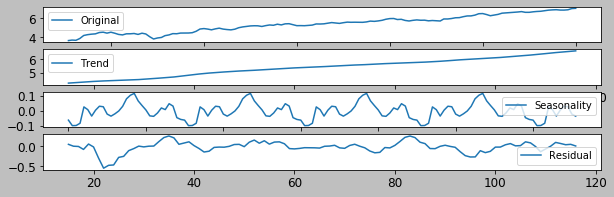

<Figure size 1440x1440 with 0 Axes>

In [330]:

from statsmodels.tsa.seasonal import seasonal_decompose

#indexeddataset_log = pd.DataFrame(data=indexeddataset_log.values, freq=30)
decomposition = seasonal_decompose(indexeddataset_log.values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexeddataset_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label ='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.figure(figsize=(20,20))
plt.tight_layout()

In [331]:
#So this graph represents upward trend-line, It is linear in nature. We have seasonality also present.
#Residual is irregularity present in data which is irregular. 
print(decomposeLogData)
print(residual)

[ 5.02472455e-02  3.62835070e-03 -2.92235058e-03 -7.66550412e-02
  5.77802957e-02 -1.52548272e-02 -2.92776126e-01 -5.44767499e-01
 -4.73127453e-01 -4.64529000e-01 -2.75281811e-01 -2.49428404e-01
 -1.06976495e-01 -5.64920239e-02  5.99425430e-03 -1.35129805e-02
  3.76066652e-03  7.55371253e-03  1.18235378e-01  2.19223344e-01
  2.59224407e-01  2.12027994e-01  5.12955651e-02  8.07783916e-02
  1.13000078e-01  1.91992494e-02 -5.35269479e-02 -1.41039831e-01
 -1.21464141e-01 -2.62322715e-02 -1.80758117e-02 -2.10660584e-02
  2.49101243e-04  4.55573065e-02  4.99765653e-02 -7.91923535e-03
  1.03558165e-01  1.56705352e-01  7.80700865e-02  1.39761578e-01
  5.55678339e-02  1.06395900e-01  1.12219347e-01  6.49089495e-02
 -5.59723310e-02 -6.33488819e-02 -5.17294407e-02 -3.34525247e-02
 -3.39484563e-02 -3.65125415e-02 -4.30151836e-02  2.12156842e-03
  7.58286777e-03  2.66662573e-02 -3.76166171e-02 -4.93876965e-02
  2.22071899e-02  5.25584335e-02  3.48073026e-03 -3.57793606e-02
 -1.15847882e-01 -1.60997

In [332]:
#The above mentioned techiniques went really well in order to make data stationary.
#I will continue to make model after differencing. Ill choose ARIMA model(Auto-Regressive Integrated Moving Averages).

#Parameters for ARIMA model:
#1-->p: Periods to lag 
    #eg. if P= 3 then we will use the three previous periods of our time series in the autoregressive portion.
    #P in other words AR(autoregressive)model helps to adjust the line that is being fitted to forecast the series.
    
#2-->q: This variable denotes the lag of the error component.

#3-->d = differencing value to transform non stationary data into stationary data. I used this in differencing technique.

In [333]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf,pacf

In [334]:
lags_acf = acf(datasetLogShift, nlags=20)
lags_pacf =pacf(datasetLogShift, nlags=20, method='ols')    

C:\Users\Amol\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


# Plot ACF(Auto-Regressive)

Text(0.5, 1.0, 'Autocorrelation function')

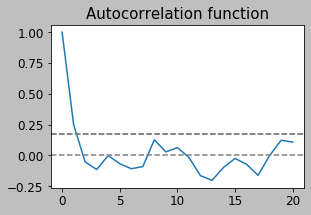

In [335]:
#ACF: (Autocorrelation Function plots (ACF))
#It tells how the time series is correlated with its past values. We use ACF plot to determine the value of q(Auto-Regressive)

plt.subplot(121)
plt.plot(lags_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogShift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogShift)), linestyle='--', color='gray')
plt.title('Autocorrelation function')    

# Plot PACF(Moving Average)

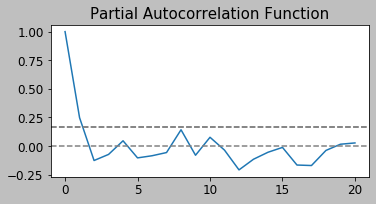

In [336]:
#PACF tells the summary of the relationship between an observation in a time series with observations at prior time.
#MA terms are lagged forecast errors in prediction equation. 

plt.subplot(122)
plt.plot(lags_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogShift)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogShift)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [337]:
#In above plots, p –> 2 from PACF plot and q -> 2 ACF plot.

#Now, lets make 3 different ARIMA models AR, MA and combined ARIMA(AR+MA). 
#The p,d,q values can be specified using the order of (p,d,q) in ARIMA model.
#I will measure RSS which represent the values of residuals and not actual series.

In [338]:
from statsmodels.tsa.arima_model import ARIMA

# AR Model(Auto-Regressive Model)

Plotting AR model


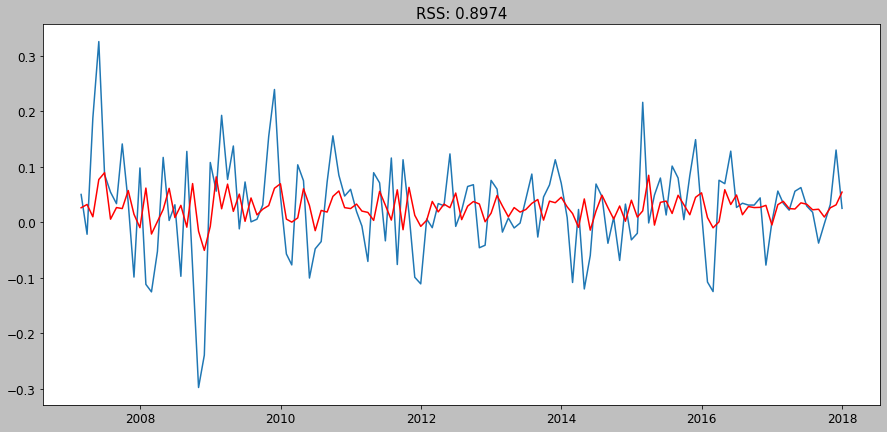

In [339]:
#AR model
plt.figure(figsize=(15,7))
model = ARIMA(indexeddataset_log, order = (2,1,0))
result_AR = model.fit(disp=-1)
plt.plot(datasetLogShift)
plt.plot(result_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_AR.fittedvalues-datasetLogShift["Close"])**2))
print('Plotting AR model')

# MA Model (Moving Average)

Plotting MA model


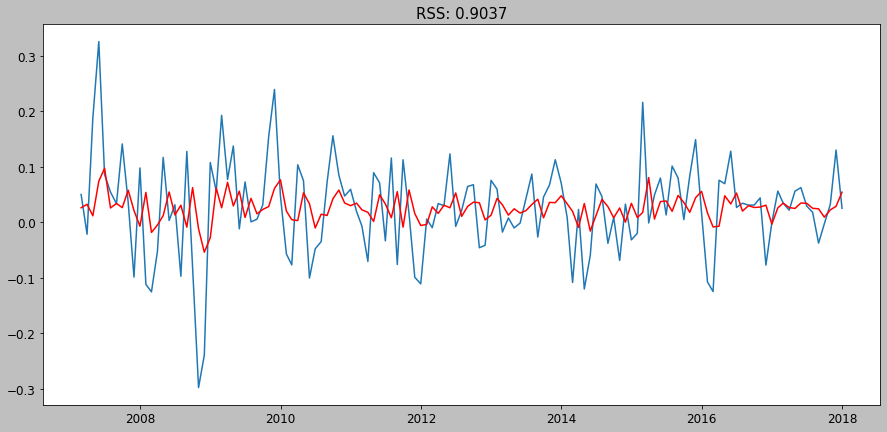

In [340]:
#MA model
plt.figure(figsize=(15,7))
model = ARIMA(indexeddataset_log, order = (0,1,2))
result_MA = model.fit(disp=-1)
plt.plot(datasetLogShift)
plt.plot(result_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_MA.fittedvalues-datasetLogShift["Close"])**2))
print('Plotting MA model')

# Plotting ARIMA model:

Plotting ARIMA model


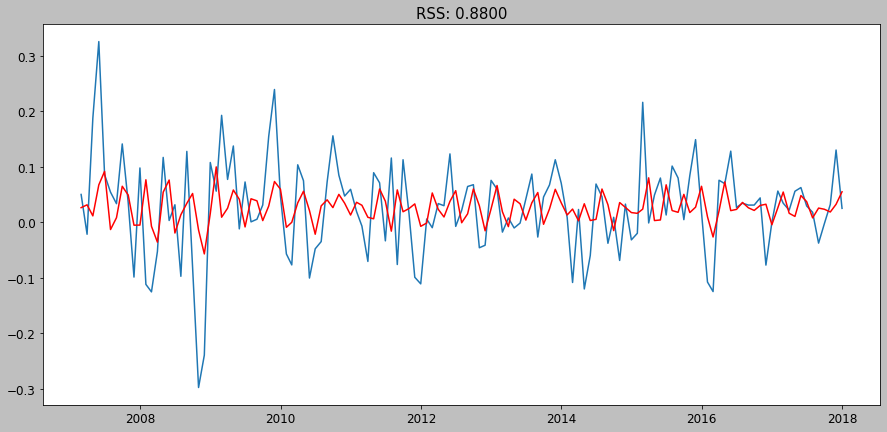

In [341]:
#Combine the model
plt.figure(figsize=(15,7))
model = ARIMA(indexeddataset_log, order = (2,1,2))
result_ARIMA= model.fit(disp=-1)
plt.plot(datasetLogShift)
plt.plot(result_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result_ARIMA.fittedvalues-datasetLogShift['Close'])**2))
print('Plotting ARIMA model')

In [342]:
#Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. 
#Now, we are left with 1 last step, i.e. taking these values back to the original scale.

# Scale data back to the original scale


In [343]:
Prediction_ARIMA = pd.Series(result_ARIMA.fittedvalues, copy=True)
Prediction_ARIMA.head()

Date
2007-02-28    0.026400
2007-03-31    0.031509
2007-04-30    0.011588
2007-05-31    0.067359
2007-06-30    0.091660
Freq: M, dtype: float64

In [344]:
#As data is in lag scale format, cumulative sum to scale back to original format 
Prediction_ARIMA_cumsum = Prediction_ARIMA.cumsum()
Prediction_ARIMA.head()

Date
2007-02-28    0.026400
2007-03-31    0.031509
2007-04-30    0.011588
2007-05-31    0.067359
2007-06-30    0.091660
Freq: M, dtype: float64

In [345]:
predictions_ARIMA_log = pd.Series(indexeddataset_log['Close'].iloc[0], index=indexeddataset_log.index)
predictions_ARIMA_log= predictions_ARIMA_log.add(Prediction_ARIMA_cumsum, fill_value=0)
#predictions_ARIMA_log.head()
predictions_ARIMA_log.tail()

Date
2017-08-31    6.960442
2017-09-30    6.983984
2017-10-31    7.002590
2017-11-30    7.035039
2017-12-31    7.090012
Freq: M, dtype: float64

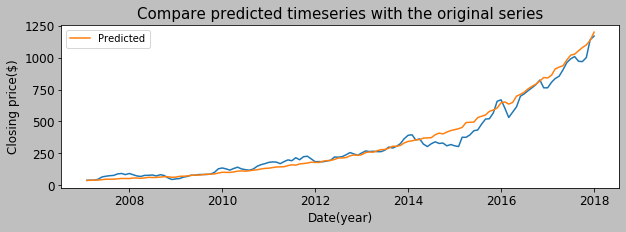

In [353]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexeddataset)
plt.plot(predictions_ARIMA, label='Predicted')
plt.xlabel('Date(year)')
plt.ylabel('Closing price($)')
plt.title('Compare predicted timeseries with the original series')
plt.legend(loc='best')
plt.show()

In [354]:
indexeddataset_log

,Close
Date,
2007-01-31,3.626020
2007-02-28,3.676181
2007-03-31,3.654700
2007-04-30,3.842233
2007-05-31,4.167581
...,...
2017-08-31,6.878776
2017-09-30,6.876257
2017-10-31,6.908475


# Future Forecasting 

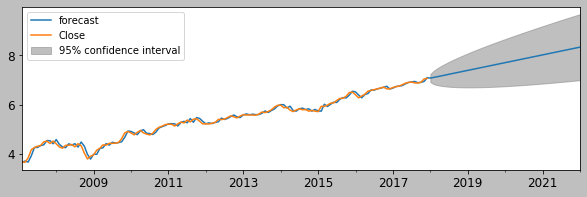

In [348]:
#Here forecasting the closing stock price for three years from 2019 to 2021.
result_AR.plot_predict(1,180)
x = result_AR.forecast(steps=48)

#From this graph, I can clearly says that the price of Amazon stock price will be increase in the future upto 2021.
#The confidence level means that the predicted line will not be fall beyond that interval.

In [349]:
print(x)

(array([7.07676429, 7.09943213, 7.12630088, 7.1531353 , 7.17943791,
       7.20559691, 7.23178208, 7.2579924 , 7.28420644, 7.3104184 ,
       7.33662932, 7.3628402 , 7.38905121, 7.41526225, 7.44147329,
       7.46768433, 7.49389536, 7.52010639, 7.54631742, 7.57252846,
       7.59873949, 7.62495052, 7.65116155, 7.67737259, 7.70358362,
       7.72979465, 7.75600568, 7.78221672, 7.80842775, 7.83463878,
       7.86084981, 7.88706085, 7.91327188, 7.93948291, 7.96569395,
       7.99190498, 8.01811601, 8.04432704, 8.07053808, 8.09674911,
       8.12296014, 8.14917117, 8.17538221, 8.20159324, 8.22780427,
       8.2540153 , 8.28022634, 8.30643737]), array([0.08276236, 0.13430625, 0.16857912, 0.19496608, 0.21791047,
       0.23878971, 0.25804719, 0.27596627, 0.29278445, 0.30868578,
       0.32380738, 0.33825391, 0.35210827, 0.36543775, 0.37829783,
       0.39073489, 0.40278811, 0.41449097, 0.42587236, 0.4369574 ,
       0.44776811, 0.45832388, 0.46864196, 0.47873771, 0.4886249 ,
       0.4983159